# XGBoost

This notebook will be used to tune and evaluate the XGBoost model.

We will tune the model hyperparameters using crossvalidation and trying to different scores: balanced_accuracy and f1_weighted. We also have a variable 'noise_event_laeq_primary_detected_certainty' which account for how certain it is that a noise was labeled correctly. We will consider models with and without these variable. 

Therefore, we need to tune and evaluate four different scenarios:
- certainty + balanced_accuracy
- certainty + f1_weighted
- no certainty + balanced_accuracy
- no certainty + f1_weighted

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, balanced_accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.model_datatransforms import *

---
# Data Loading

In [2]:
df = pd.read_parquet('data/pred_model_data_full.parquet')

In [3]:
df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Unsupported                       20791
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Music non-amplified                 126
Nature elements - Wind              113
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [4]:
conditions = df['noise_event_laeq_primary_detected_class'].isin(['Music non-amplified', 'Nature elements - Wind', 'Unsupported'])
df.loc[conditions, 'noise_event_laeq_primary_detected_class'] = 'Other'

df.noise_event_laeq_primary_detected_class.value_counts()

Transport road - Passenger car    47386
Other                             21030
Human voice - Shouting             5742
Transport road - Siren             1992
Human voice - Singing              1082
Name: noise_event_laeq_primary_detected_class, dtype: int64

In [6]:
X = df.drop(columns=['noise_event_laeq_primary_detected_class'])

le = LabelEncoder()
y = le.fit_transform(df[['noise_event_laeq_primary_detected_class']])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

c:\Users\anaso\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
X['noise_event_laeq_primary_detected_certainty']=X['noise_event_laeq_primary_detected_certainty']/100
X.noise_event_laeq_primary_detected_certainty

0        0.97
1        0.78
2        0.98
3        1.00
4        1.00
         ... 
77227    0.96
77228    0.98
77229    0.85
77230    0.00
77231    0.00
Name: noise_event_laeq_primary_detected_certainty, Length: 77232, dtype: float64

In [8]:
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
class_weights

array([0.73027151, 0.32680671, 0.32680671, ..., 0.32680671, 0.32680671,
       0.32680671])

In [9]:
n_classes=len(df.noise_event_laeq_primary_detected_class.unique())
n_classes

5

---
# Certainty + balanced_accuracy

In [59]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday']
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes))
])

In [50]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.7214215374229496

In [60]:
#choose parameters
n_estimators = np.arange(200,400,50) 
learning_rate = np.arange(0.2,0.7,0.1)
max_depth = np.arange(2,12,2) 

random_grid = {
    # Parameters that we are going to tune
    'month_handler__strategy': ['month', 'season'], 
    'day_of_the_week_handler__strategy': ['full', 'weekend'], 
    'custom_encoder__strategy': ['one_hot', 'binary'], 
    'xgb__n_estimators': n_estimators,
    'xgb__learning_rate': learning_rate,
    'xgb__max_depth': max_depth
}

In [61]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=50, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train, xgb__sample_weight=class_weights)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.8050208552806605
Best Parameters: {'xgb__n_estimators': 200, 'xgb__max_depth': 4, 'xgb__learning_rate': 0.3, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [62]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy="month")
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy="full")
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy="one_hot")
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes, n_estimators=200, max_depth=4, learning_rate=0.3))
   ])


In [63]:
pipeline.fit(X_train, y_train, xgb__sample_weight=class_weights)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_id', 'day_period', 'month',
                                        'weekday'])),
                ('pca',
                 PC...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_

In [64]:
y_pred = pipeline.predict(X_test)

In [65]:
y_pred_proba = pipeline.predict_proba(X_test)

In [66]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.918256365990505
Balanced Accuracy: 0.8182321329025642


In [67]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.9686277646626049

In [68]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

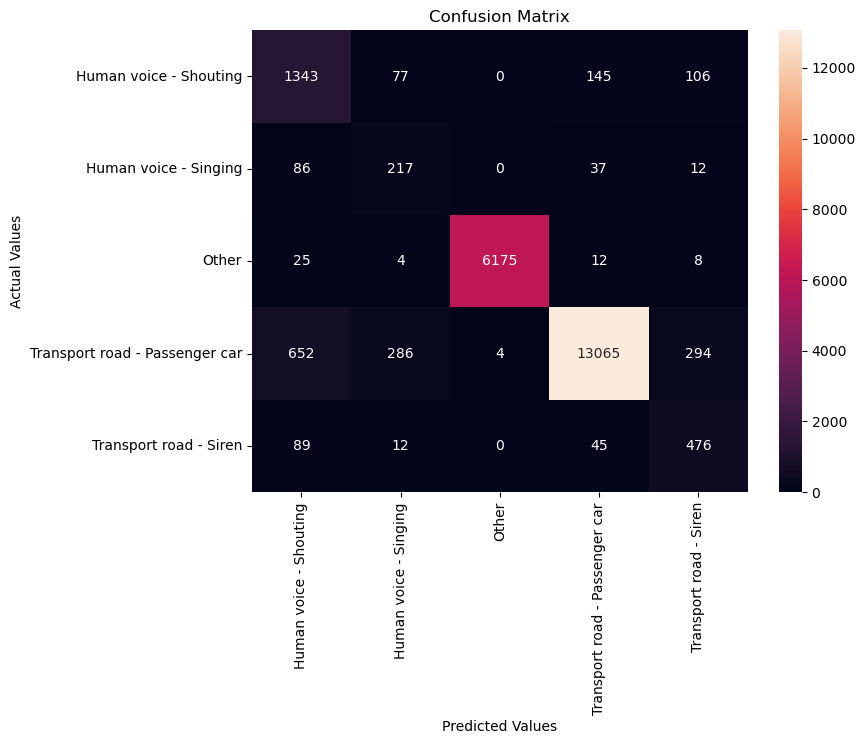

In [69]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [70]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.61      0.80      0.69      1671
         Human voice - Singing       0.36      0.62      0.46       352
                         Other       1.00      0.99      1.00      6224
Transport road - Passenger car       0.98      0.91      0.95     14301
        Transport road - Siren       0.53      0.77      0.63       622

                      accuracy                           0.92     23170
                     macro avg       0.70      0.82      0.74     23170
                  weighted avg       0.94      0.92      0.93     23170



---
# Certainty + F1-weighted

In [10]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday']
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes))
])

In [29]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.9456223987022101

In [11]:
#choose parameters
n_estimators = np.arange(200,600,100)
learning_rate = np.array([0.1,0.3,0.5,0.7])
max_depth = np.arange(4,9)

random_grid = {
    # Parameters that we are going to tune
    'month_handler__strategy': ['month'], #,'season'
    'day_of_the_week_handler__strategy': ['full'], #, 'weekend'
    'custom_encoder__strategy': ['one_hot'], #, 'binary'
    'xgb__n_estimators': n_estimators,
    'xgb__learning_rate': learning_rate,
    'xgb__max_depth': max_depth
}

In [12]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=50, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train, xgb__sample_weight=class_weights)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.9477314826798645
Best Parameters: {'xgb__n_estimators': 400, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.3, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [14]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    #'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes,  n_estimators=400, max_depth=7, learning_rate=0.3))
])

In [15]:
pipeline.fit(X_train, y_train, xgb__sample_weight=class_weights)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_id', 'day_period', 'month',
                                        'weekday'])),
                ('pca',
                 PC...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_

In [16]:
y_pred = pipeline.predict(X_test)

In [17]:
y_pred_proba = pipeline.predict_proba(X_test)

In [18]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.9512300388433319
Balanced Accuracy: 0.7831747941093641


In [19]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.9671378790698597

In [20]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

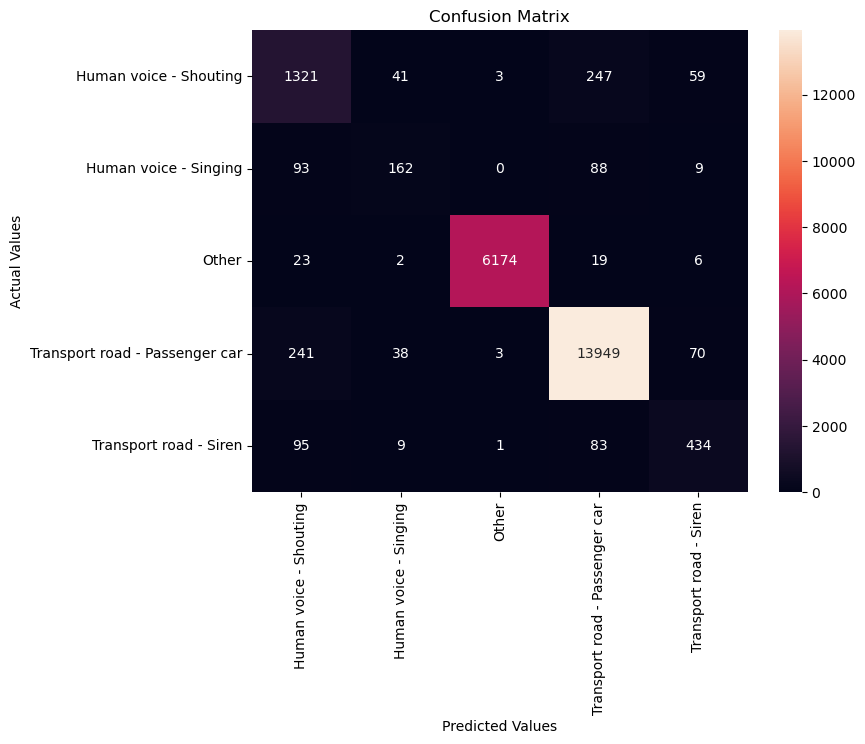

In [21]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [22]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.75      0.79      0.77      1671
         Human voice - Singing       0.64      0.46      0.54       352
                         Other       1.00      0.99      1.00      6224
Transport road - Passenger car       0.97      0.98      0.97     14301
        Transport road - Siren       0.75      0.70      0.72       622

                      accuracy                           0.95     23170
                     macro avg       0.82      0.78      0.80     23170
                  weighted avg       0.95      0.95      0.95     23170



---
# No certainty + balanced_accuracy

In [23]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday']
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes))
])

In [24]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='balanced_accuracy', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.4814382635251248

In [25]:
#choose parameters
n_estimators = np.arange(100,600,100)
learning_rate = np.array([0.01,0.1,0.3, 0.5])
max_depth = np.arange(2,17,3)

random_grid = {
    # Parameters that we are going to tune
    'month_handler__strategy': ['month','season'], 
    'day_of_the_week_handler__strategy': ['full', 'weekend'], 
    'custom_encoder__strategy': ['one_hot', 'binary'], 
    'xgb__n_estimators': n_estimators,
    'xgb__learning_rate': learning_rate,
    'xgb__max_depth': max_depth
}

In [26]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=50, scoring='balanced_accuracy')

# Find optimal parameters
search.fit(X_train, y_train, xgb__sample_weight=class_weights)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

Best Score: 0.6262439586095742
Best Parameters: {'xgb__n_estimators': 200, 'xgb__max_depth': 2, 'xgb__learning_rate': 0.3, 'month_handler__strategy': 'month', 'day_of_the_week_handler__strategy': 'full', 'custom_encoder__strategy': 'one_hot'}


## Model Evaluation

In [37]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes,  n_estimators=200, max_depth=2, learning_rate=0.3))
])

In [38]:
pipeline.fit(X_train, y_train, xgb__sample_weight=class_weights)

Pipeline(steps=[('day_period_handler', DayPeriodHandler()),
                ('month_handler', MonthHandler()),
                ('day_of_the_week_handler', DayoftheWeekHandler()),
                ('column_dropper',
                 ColumnDropper(columns_to_drop=['date', 'hour', 'minute',
                                                'second',
                                                'noise_event_laeq_model_id',
                                                'noise_event_laeq_primary_detected_certainty'])),
                ('custom_encoder',
                 CustomEncoder(columns=['#object_i...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                  

In [39]:
y_pred = pipeline.predict(X_test)

In [40]:
y_pred_proba = pipeline.predict_proba(X_test)

In [41]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

Accuracy: 0.6410012947777298
Balanced Accuracy: 0.6354658309743623


In [33]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

0.9650049259600241

In [34]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

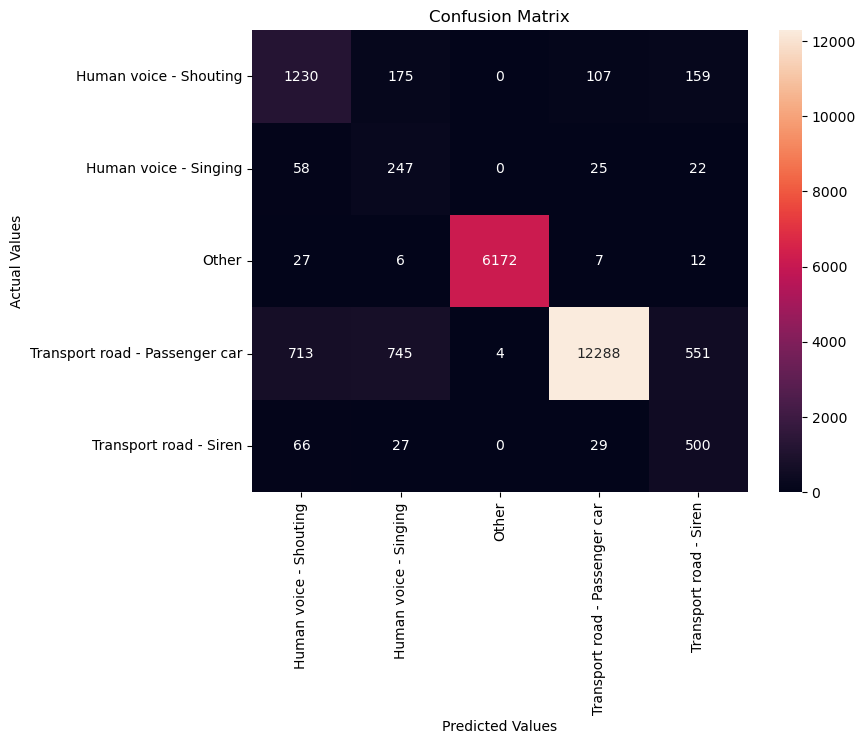

In [42]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [43]:
print(classification_report(y_test, y_pred, target_names=classes))

                                precision    recall  f1-score   support

        Human voice - Shouting       0.40      0.66      0.50      1671
         Human voice - Singing       0.10      0.66      0.18       352
                         Other       0.50      0.31      0.39      6224
Transport road - Passenger car       0.87      0.78      0.82     14301
        Transport road - Siren       0.31      0.78      0.44       622

                      accuracy                           0.64     23170
                     macro avg       0.44      0.64      0.46     23170
                  weighted avg       0.71      0.64      0.66     23170



---
# No certainty + f1_weighted

In [35]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler()
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler()
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday']
        )
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes))
])

In [36]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
scores3 = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, error_score='raise', n_jobs=-1)
scores3.mean()

0.7384575215739

In [ ]:
#choose parameters
n_estimators = np.arange(200,500,100)
learning_rate = np.array([0.01,0.1,0.3, 0.5])
max_depth = np.arange(2,6)

random_grid = {
    # Parameters that we are going to tune
    'month_handler__strategy': ['month'], #,'season'
    'day_of_the_week_handler__strategy': ['full'], #, 'weekend'
    'custom_encoder__strategy': ['one_hot'], #, 'binary'
    'xgb__n_estimators': n_estimators,
    'xgb__learning_rate': learning_rate,
    'xgb__max_depth': max_depth,
}

In [ ]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = RandomizedSearchCV(pipeline, param_distributions=random_grid, n_jobs=-1, cv=cv, n_iter=1, scoring='f1_weighted')

# Find optimal parameters
search.fit(X_train, y_train, xgb__sample_weight=class_weights)

print("Best Score:", search.best_score_)
print("Best Parameters:", search.best_params_)

## Model Evaluation

In [ ]:
pipeline = Pipeline(steps=[
    ('day_period_handler',
     DayPeriodHandler()
     ),
    ('month_handler',
     MonthHandler(strategy='month')
     ),
    ('day_of_the_week_handler',
     DayoftheWeekHandler(strategy='full')
     ),
    ('column_dropper',
     ColumnDropper(columns_to_drop=[
    'date', 
    'hour',
    'minute',
    'second',
    'noise_event_laeq_model_id',
    'noise_event_laeq_primary_detected_certainty'
    ])
     ),
    ('custom_encoder',
     CustomEncoder(
        columns=['#object_id', 'day_period', 'month', 'weekday'],
        strategy='one_hot')
     ),
    ('pca',
     PCATransformer(
        n_components=7,
        columns=[
            'lamax', 'laeq', 'lceq', 'lcpeak',
            'lamax_shift_t-_1', 'laeq_shift_t-_1', 'lceq_shift_t-_1',
            'lcpeak_shift_t-_1', 'lamax_shift_t-_2', 'laeq_shift_t-_2',
            'lceq_shift_t-_2', 'lcpeak_shift_t-_2', 'lamax_shift_t-_3',
            'laeq_shift_t-_3', 'lceq_shift_t-_3', 'lcpeak_shift_t-_3',
            'lamax_shift_t-_4', 'laeq_shift_t-_4', 'lceq_shift_t-_4',
            'lcpeak_shift_t-_4', 'lamax_shift_t-_5', 'laeq_shift_t-_5',
            'lceq_shift_t-_5', 'lcpeak_shift_t-_5'
        ])
     ),
     ('xgb', XGBClassifier(random_state=42, objective='multi:softmax', num_class=n_classes,  n_estimators=200, max_depth=2, learning_rate=0.3))
])

In [ ]:
pipeline.fit(X_train, y_train, xgb__sample_weight=class_weights)

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
y_pred_proba = pipeline.predict_proba(X_test)

In [ ]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Balanced Accuracy:', balanced_accuracy_score(y_test, y_pred))

In [ ]:
roc_auc_score(y_test, y_pred_proba, multi_class='ovo')

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Define the class labels
classes = list(le.classes_)

cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.heatmap(cm_df, annot=True, fmt='.0f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')

plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=classes))